In [1]:
!nvcc --version
!pip install cupy-cuda12x

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [2]:
import cupy as cp

# Check if a GPU is available to CuPy
try:
    dev = cp.cuda.Device(0)
    print(f"Success! CuPy is using GPU: {dev.attributes['MultiProcessorCount']} multiprocessors found.")

    # Quick test: Create an array on the GPU
    x = cp.array([1, 2, 3])
    print("GPU Array:", x)
except Exception as e:
    print("CuPy installed, but GPU not detected:", e)

Success! CuPy is using GPU: 40 multiprocessors found.
GPU Array: [1 2 3]


In [7]:
import os
import sys
import numpy as np
import cupy as cp
import kagglehub
import pandas as pd

# --- RAPIDS IMPORTS ---
import cudf
from cuml.model_selection import train_test_split, GridSearchCV
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import accuracy_score, confusion_matrix, roc_auc_score
from cuml.preprocessing import StandardScaler

# --- SCIKIT-LEARN IMPORTS (for CPU-based tasks) ---
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold as SklearnStratifiedKFold

# --- PLOTTING (CPU-based) ---
import seaborn as sns
import matplotlib.pyplot as plt

# --- Configuration ---
SELECTED_COLUMNS = [
    'months', 'marital', 'adults', 'hnd_price', 'new_cell', 'ownrent',
    'dwlltype', 'lor', 'dwllsize', 'infobase', 'numbcars', 'HHstatin',
    'forgntvl', 'ethnic', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15',
    'kid16_17', 'creditcd', 'eqpdays', 'rev_Mean', 'mou_Mean', 'totmrc_Mean',
    'change_mou', 'change_rev', 'churn'
]

# --- Data Loading (GPU) ---
def load_and_preprocess_data_gpu():
    print("Step 1: Locating dataset via Kaggle Hub...")
    dataset_folder_path = kagglehub.dataset_download("abhinav89/telecom-customer")
    csv_file_path = os.path.join(dataset_folder_path, "Telecom_customer churn.csv")

    print(f"Loading data from: {csv_file_path}")
    gdf = cudf.read_csv(csv_file_path)
    selected_columns_present = [col for col in SELECTED_COLUMNS if col in gdf.columns]
    gdf_selected = gdf[selected_columns_present].copy()

    print("Step 2: Handling missing values and encoding on GPU...")
    y = gdf_selected['churn'].astype('int32')
    X = gdf_selected.drop('churn', axis=1)

    numerical_cols = X.select_dtypes(include=np.number).columns.to_list()
    categorical_cols = X.select_dtypes(include=['object']).columns.to_list()

    for col in numerical_cols:
        X[col] = X[col].fillna(X[col].median()).astype('float32')

    if categorical_cols:
         for col in categorical_cols:
             mode_val = X[col].mode().iloc[0]
             X[col] = X[col].fillna(mode_val)

    X = cudf.get_dummies(X, columns=categorical_cols, drop_first=True, dtype='float32')
    return X, y

# --- Model Training & Evaluation Logic (GPU) ---
def evaluate_model_performance_gpu(model, X_test: cudf.DataFrame, y_test: cudf.Series) -> dict:
    """Calculates performance metrics for a trained model."""
    # 1. Generate predictions
    y_pred = model.predict(X_test)
    y_prob_output = model.predict_proba(X_test)

    # 2. Extract probability of class 1
    if isinstance(y_prob_output, cudf.DataFrame):
        y_prob = y_prob_output.iloc[:, 1]
    else:
        y_prob = y_prob_output[:, 1]

    # 3. Ensure everything is a GPU-backed array (CuPy) and correctly typed
    # This prevents the 'ValueError: Must specify dtype' for the metric functions
    y_pred_gpu = cp.asarray(y_pred).astype(cp.int32)
    y_test_gpu = cp.asarray(y_test).astype(cp.int32)
    y_prob_gpu = cp.asarray(y_prob).astype(cp.float32)

    # FIX: Convert labels list to a typed CuPy array to avoid the error
    labels_gpu = cp.array([0, 1], dtype=cp.int32)

    # 4. Calculate metrics
    acc = accuracy_score(y_test_gpu, y_pred_gpu)
    cm = confusion_matrix(y_test_gpu, y_pred_gpu, labels=labels_gpu)
    auc = roc_auc_score(y_test_gpu, y_prob_gpu)

    # 5. Get ROC curve data (requires CPU/Numpy)
    y_test_cpu = cp.asnumpy(y_test_gpu)
    y_prob_cpu = cp.asnumpy(y_prob_gpu)
    fpr, tpr, _ = roc_curve(y_test_cpu, y_prob_cpu)

    return {
        "accuracy": float(acc),
        "confusion_matrix": cm,
        "fpr": fpr, "tpr": tpr,
        "roc_auc": float(auc)
    }

def train_and_evaluate_original_models_gpu(X_train, X_test, y_train, y_test):
    print("\n--- Training and Evaluating Original Models on GPU ---")
    models = {
        "Logistic Regression": LogisticRegression(solver='qn', tol=1e-3),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
    }
    results = {}
    for name, model in models.items():
        print(f"Training Original {name}...")
        model.fit(X_train, y_train)
        results[name] = evaluate_model_performance_gpu(model, X_test, y_test)
    return results

def cuml_accuracy_scorer(estimator, X, y_true):
    """Scorer function for GridSearchCV."""
    y_pred = estimator.predict(X)
    # Ensure consistent types for accuracy_score
    y_true_gpu = cp.asarray(y_true).astype(cp.int32)
    y_pred_gpu = cp.asarray(y_pred).astype(cp.int32)
    return accuracy_score(y_true_gpu, y_pred_gpu)

def train_and_evaluate_tuned_models_gpu(X_train, X_test, y_train, y_test):
    print("\n--- Tuning Models on GPU with GridSearchCV ---")
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(random_state=42)
    }
    param_grids = {
        "Logistic Regression": {
            'C': [0.1, 1.0, 10.0],
            'solver': ['lbfgs', 'qn'],
            'tol': [1e-4, 1e-3]
        },
        "Random Forest": {
            'n_estimators': [100, 200],
            'max_depth': [10, 20],
            'min_samples_leaf': [2, 4]
        }
    }
    results = {}
    # Convert y_train to numpy for sklearn CV splitter compatibility
    y_train_cpu = y_train.to_numpy()

    for name, model in models.items():
        print(f"Tuning {name}...")
        cv_splitter = SklearnStratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            model, param_grids[name], cv=cv_splitter, scoring=cuml_accuracy_scorer
        )
        grid_search.fit(X_train, y_train_cpu)
        print(f"Best Parameters for {name}: {grid_search.best_params_}")
        results[name] = evaluate_model_performance_gpu(grid_search.best_estimator_, X_test, y_test)
    return results

# --- Visualization & Logging ---
def plot_visualizations(results, model_type, split_output_dir, split_ratio_str):
    num_models = len(results)
    fig_cm, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5), squeeze=False)
    axes = axes.flatten()
    fig_cm.suptitle(f'Confusion Matrices for {model_type} Models ({split_ratio_str} Split)', fontsize=16)

    for i, (name, result) in enumerate(results.items()):
        cm_cpu = cp.asnumpy(result["confusion_matrix"])
        sns.heatmap(cm_cpu, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(name)
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(split_output_dir, f'confusion_matrices_{model_type.lower()}.png'))
    plt.close(fig_cm)

    fig_roc = plt.figure(figsize=(10, 8))
    for name, result in results.items():
        plt.plot(result["fpr"], result["tpr"], lw=2, label=f'{name} (AUC = {result["roc_auc"]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(f'ROC Curve for {model_type} Models ({split_ratio_str} Split)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(os.path.join(split_output_dir, f'roc_curve_{model_type.lower()}.png'))
    plt.close(fig_roc)

def log_model_results(log_file_path, original_results, tuned_results, split_ratio_str):
    with open(log_file_path, 'w') as f:
        f.write(f"--- Performance Summary for {split_ratio_str} Split ---\n\n")
        for s_name, s_res in [("Original Models", original_results), ("Tuned Models", tuned_results)]:
            f.write(f"--- {s_name} ---\n")
            for name, metrics in s_res.items():
                f.write(f"Model: {name}\n")
                f.write(f"  Accuracy: {metrics['accuracy']:.4f}\n")
                f.write(f"  ROC AUC: {metrics['roc_auc']:.4f}\n")
                cm_cpu = cp.asnumpy(metrics['confusion_matrix'])
                df_cm = pd.DataFrame(cm_cpu, columns=['Pred 0', 'Pred 1'], index=['Actual 0', 'Actual 1'])
                f.write(f"  Confusion Matrix:\n{df_cm.to_string()}\n\n")

# --- Main Execution ---
def main():
    output_dir = 'output_gpu10'
    os.makedirs(output_dir, exist_ok=True)
    X, y = load_and_preprocess_data_gpu()
    train_sizes = [0.6, 0.7, 0.8, 0.9]
    all_results_summary = []

    for train_size in train_sizes:
        train_ratio = int(train_size * 100)
        split_ratio_str = f"{train_ratio}_{100-train_ratio}"
        split_output_dir = os.path.join(output_dir, split_ratio_str)
        os.makedirs(split_output_dir, exist_ok=True)

        print(f"\n--- Analysis for {split_ratio_str} Split ---")
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42, stratify=y)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        original_results = train_and_evaluate_original_models_gpu(X_train_scaled, X_test_scaled, y_train, y_test)
        tuned_results = train_and_evaluate_tuned_models_gpu(X_train_scaled, X_test_scaled, y_train, y_test)

        log_model_results(os.path.join(split_output_dir, 'analysis_output.txt'), original_results, tuned_results, split_ratio_str)
        plot_visualizations(original_results, "Original", split_output_dir, split_ratio_str)
        plot_visualizations(tuned_results, "Tuned", split_output_dir, split_ratio_str)

        for name in original_results.keys():
            all_results_summary.append({"Split Ratio": split_ratio_str, "Model": name, "Type": "Original", "Accuracy": original_results[name]['accuracy']})
            all_results_summary.append({"Split Ratio": split_ratio_str, "Model": name, "Type": "Tuned", "Accuracy": tuned_results[name]['accuracy']})

    final_df = pd.DataFrame(all_results_summary)
    print("\nFinal Accuracy Scores:\n", final_df.pivot_table(index=['Model', 'Type'], columns='Split Ratio', values='Accuracy'))

if __name__ == "__main__":
    main()

Step 1: Locating dataset via Kaggle Hub...
Using Colab cache for faster access to the 'telecom-customer' dataset.
Loading data from: /kaggle/input/telecom-customer/Telecom_customer churn.csv
Step 2: Handling missing values and encoding on GPU...

--- Analysis for 60_40 Split ---

--- Training and Evaluating Original Models on GPU ---
Training Original Logistic Regression...
Training Original Random Forest...

--- Tuning Models on GPU with GridSearchCV ---
Tuning Logistic Regression...
[2026-01-08 13:15:44.705] [CUML] [warning] L-BFGS line search failed (code 3); stopping at the last valid step
Best Parameters for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs', 'tol': 0.001}
Tuning Random Forest...
Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 4, 'n_estimators': 200}

--- Analysis for 70_30 Split ---

--- Training and Evaluating Original Models on GPU ---
Training Original Logistic Regression...
Training Original Random Forest...

--- Tuning Models on GPU w

Locating dataset via Kaggle Hub...
Using Colab cache for faster access to the 'telecom-customer' dataset.
Loading data from: /kaggle/input/telecom-customer/Telecom_customer churn.csv


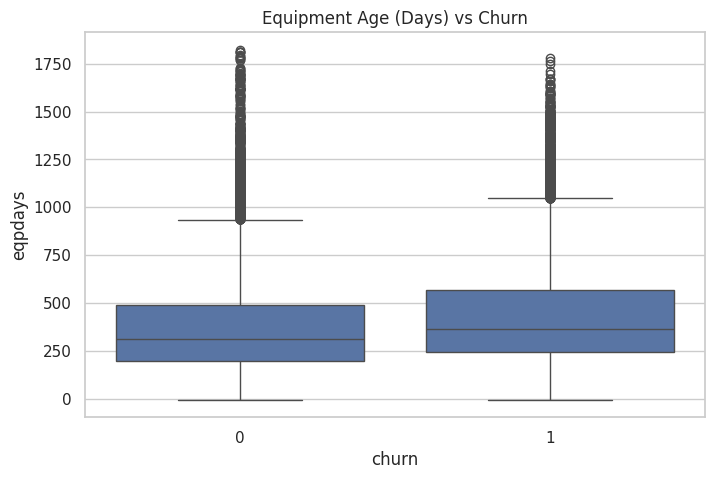

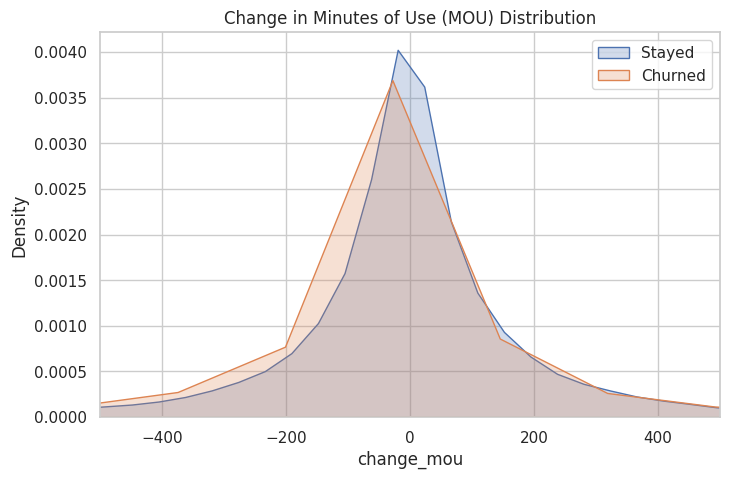

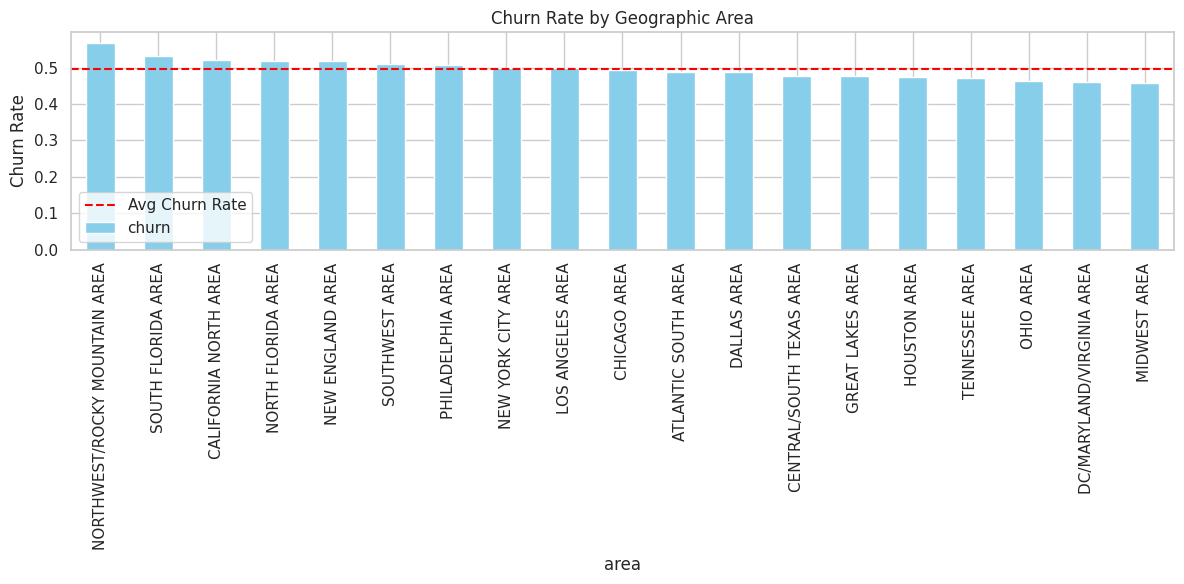

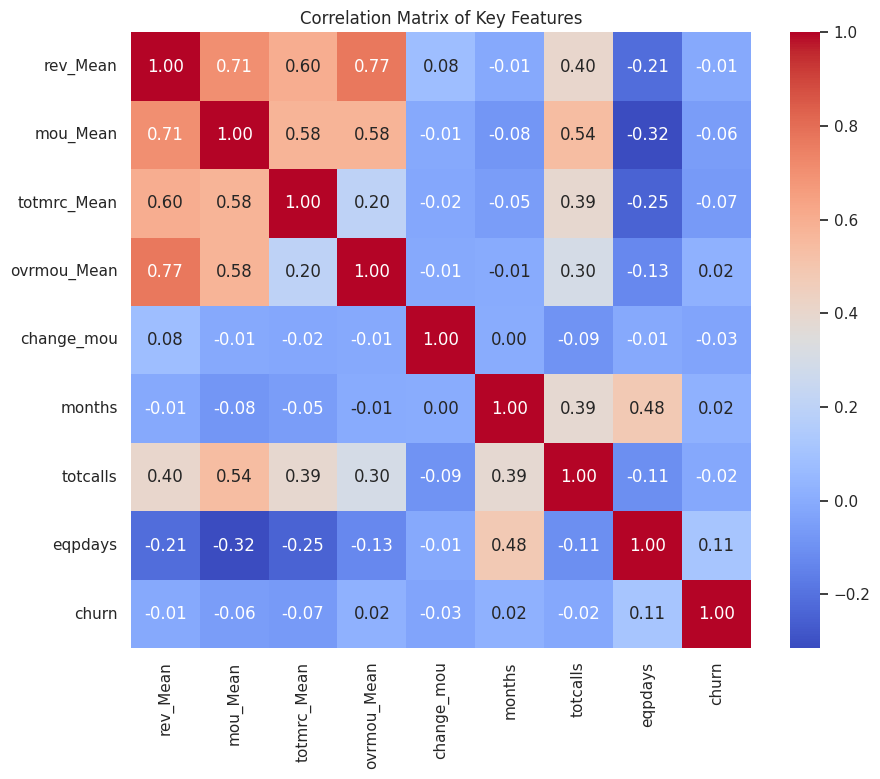

In [6]:
import os
import pandas as pd
import cudf
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Reuse your logic to get the correct file path
print("Locating dataset via Kaggle Hub...")
dataset_folder_path = kagglehub.dataset_download("abhinav89/telecom-customer")
csv_file_path = os.path.join(dataset_folder_path, "Telecom_customer churn.csv")

# 2. Load with cudf (GPU) for speed, then convert to pandas for plotting
print(f"Loading data from: {csv_file_path}")
gdf = cudf.read_csv(csv_file_path)
df = gdf.to_pandas() # Plotting libraries like Seaborn require pandas DataFrames

# Set aesthetic style
sns.set(style="whitegrid")

# --- EDA VISUALIZATIONS ---

# A. Equipment Age vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(x='churn', y='eqpdays', data=df)
plt.title('Equipment Age (Days) vs Churn')
plt.show()

# B. Usage Change vs Churn
plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['churn'] == 0]['change_mou'].dropna(), label='Stayed', fill=True)
sns.kdeplot(df[df['churn'] == 1]['change_mou'].dropna(), label='Churned', fill=True)
plt.xlim(-500, 500)
plt.title('Change in Minutes of Use (MOU) Distribution')
plt.legend()
plt.show()

# C. Churn Rate by Area
area_churn = df.groupby('area')['churn'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
area_churn.plot(kind='bar', color='skyblue')
plt.axhline(df['churn'].mean(), color='red', linestyle='--', label='Avg Churn Rate')
plt.title('Churn Rate by Geographic Area')
plt.ylabel('Churn Rate')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# D. Correlation Heatmap
important_cols = [
    'rev_Mean', 'mou_Mean', 'totmrc_Mean', 'ovrmou_Mean',
    'change_mou', 'months', 'totcalls', 'eqpdays', 'churn'
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[important_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Features')
plt.show()